<a href="https://colab.research.google.com/github/Sakthiprian/Gabor-segmentation/blob/main/texture_based_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import roberts,sobel,scharr,prewitt
from scipy import ndimage as nd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import pickle

In [ ]:
orig_image=cv2.imread('/content/drive/MyDrive/segment_data/original/AABJ1.jpg')
orig_image=cv2.cvtColor(orig_image,cv2.COLOR_BGR2GRAY)

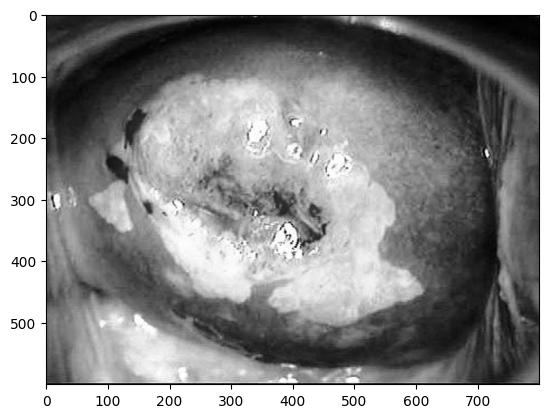

In [ ]:
plt.imshow(orig_image,cmap=plt.cm.gray)

In [ ]:
import os
from PIL import Image
import pandas as pd

# Set the path to the main folder containing patient folders
main_folder_path = "/content/drive/MyDrive/segment_data/annotated"

# Get a list of patient folders
patient_folders = [f for f in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, f))]

# Create an empty DataFrame
df = pd.DataFrame(columns=[ 'Lugols', 'Annotated'])
lugols_image=[]
annotated_image=[]
# Iterate through patient folders
for patient_folder in patient_folders:
    # Create paths to the three images for each patient
    lugols_path = os.path.join(main_folder_path, patient_folder, 'lugols.jpg')
    annotated_path = os.path.join(main_folder_path, patient_folder, 'annotation.jpg')
    example_image=np.array(Image.open(lugols_path))
    print(example_image.shape)
    lugols_image = np.array(Image.open(lugols_path).convert("RGB")).flatten()
    lugols_image = lugols_image + lugols_image.reshape(-1)
    annotated_image = np.array(Image.open(annotated_path).convert("RGB")).flatten()
    annotated_image = annotated_image + annotated_image.reshape(-1)

    # Append the flattened images to the DataFrame
df = df.append({ 'Lugols': lugols_image, 'Annotated':annotated_image}, ignore_index=True)

# Display the DataFrame
print(df)


(576, 640, 3)
(576, 640, 3)
(576, 640, 3)
(576, 640, 3)
(576, 640, 3)
(576, 640, 3)
(576, 640, 3)


<ipython-input-18-c6ae8867d954>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({ 'Lugols': lugols_image, 'Annotated': annotated_image}, ignore_index=True)
<ipython-input-18-c6ae8867d954>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({ 'Lugols': lugols_image, 'Annotated': annotated_image}, ignore_index=True)
<ipython-input-18-c6ae8867d954>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({ 'Lugols': lugols_image, 'Annotated': annotated_image}, ignore_index=True)
<ipython-input-18-c6ae8867d954>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({ 'Lugols': lugols_image, 'A

(576, 640, 3)
                                              Lugols  \
0  [27, 0, 0, 54, 24, 26, 57, 22, 28, 52, 17, 23,...   
1  [0, 8, 0, 80, 88, 75, 83, 87, 73, 80, 87, 69, ...   
2  [1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 3, ...   
3  [0, 2, 9, 31, 36, 42, 22, 27, 31, 27, 35, 38, ...   
4  [41, 0, 0, 74, 28, 30, 81, 26, 29, 85, 29, 32,...   
5  [0, 5, 2, 35, 44, 41, 32, 41, 40, 33, 42, 41, ...   
6  [1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 3, ...   
7  [0, 14, 0, 79, 100, 81, 81, 99, 83, 82, 99, 83...   

                                           Annotated  
0  [37, 5, 0, 138, 100, 89, 149, 96, 90, 157, 103...  
1  [0, 0, 5, 8, 7, 13, 7, 6, 12, 10, 9, 15, 12, 1...  
2  [0, 3, 1, 21, 27, 25, 22, 28, 26, 20, 26, 24, ...  
3  [0, 0, 10, 6, 6, 16, 2, 2, 10, 5, 5, 13, 8, 9,...  
4  [10, 0, 0, 89, 77, 79, 91, 79, 79, 92, 80, 80,...  
5  [0, 0, 0, 3, 3, 3, 1, 1, 1, 2, 2, 2, 1, 1, 1, ...  
6  [0, 0, 4, 1, 0, 5, 3, 2, 7, 0, 0, 4, 3, 2, 7, ...  
7  [0, 20, 28, 17, 50, 57, 13, 53, 55, 8,

<ipython-input-18-c6ae8867d954>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({ 'Lugols': lugols_image, 'Annotated': annotated_image}, ignore_index=True)


In [ ]:
ksize=20

In [ ]:
num=1

for theta in range(4):
    theta = theta / 4.0 * np.pi
    for sigma in (3, 5):
        for lamda in np.arange(0, np.pi, np.pi / 4.0):
            for gamma in (0.05, 0.5):
                gabor_label="gabor"+ str(num)
                gkernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
                fimg = cv2.filter2D(img, cv2.CV_8UC3, gkernel)
                filtered_img=fimg.reshape(-1)
                df[gabor_label]=filtered_img
                num+=1

ValueError: ignored

In [ ]:
canny=cv2.Canny(img,100,200)
edges=canny.reshape(-1)
df["Canny Edge"]=edges
df

,Original Pixels,gabor1,gabor2,gabor3,gabor4,gabor5,gabor6,gabor7,gabor8,gabor9,...,gabor56,gabor57,gabor58,gabor59,gabor60,gabor61,gabor62,gabor63,gabor64,Canny Edge
0,53,0,0,0,0,0,0,1,0,0,...,2,0,0,247,73,24,8,37,13,0
1,52,0,0,0,0,0,0,1,0,0,...,2,0,0,251,76,24,8,35,12,0
2,50,0,0,0,0,0,0,1,0,0,...,2,0,0,255,81,22,8,33,11,0
3,47,0,0,0,0,0,0,1,0,0,...,2,0,0,255,88,22,7,32,11,0
4,45,0,0,0,0,0,0,1,0,0,...,1,0,0,255,94,21,7,31,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479995,6,0,0,0,0,0,0,0,0,0,...,0,0,0,40,13,3,1,5,2,0
479996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,42,14,3,1,6,2,0
479997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,43,15,3,1,3,1,0
479998,4,0,0,0,0,0,0,0,0,0,...,0,0,0,43,15,3,1,4,1,0


In [ ]:
edge_roberts=roberts(orig_image)
edge_roberts=edge_roberts.reshape(-1)
df['Roberts Edge']=edge_roberts

edge_sobels=sobel(orig_image)
edge_sobels=edge_sobels.reshape(-1)
df['Sobel Edge']=edge_sobels

schr=scharr(orig_image)
schr=schr.reshape(-1)
df['Scharr']=schr

prewit=prewitt(orig_image)
prewit=prewit.reshape(-1)
df['Prewitt']=prewit


In [ ]:
df.head()

,Original Pixels,gabor1,gabor2,gabor3,gabor4,gabor5,gabor6,gabor7,gabor8,gabor9,...,gabor60,gabor61,gabor62,gabor63,gabor64,Canny Edge,Roberts Edge,Sobel Edge,Scharr,Prewitt
0,53,0,0,0,0,0,0,1,0,0,...,73,24,8,37,13,0,0.016169,0.011433,0.011433,0.011433
1,52,0,0,0,0,0,0,1,0,0,...,76,24,8,35,12,0,0.017538,0.013865,0.013865,0.013865
2,50,0,0,0,0,0,0,1,0,0,...,81,22,8,33,11,0,0.016867,0.016782,0.017025,0.016457
3,47,0,0,0,0,0,0,1,0,0,...,88,22,7,32,11,0,0.014139,0.015960,0.016007,0.015903
4,45,0,0,0,0,0,0,1,0,0,...,94,21,7,31,11,0,0.011433,0.012895,0.013137,0.012572


In [ ]:
gaus3=nd.gaussian_filter(orig_image,sigma=3)
gaus3=gaus3.reshape(-1)
df['gauss3']=gaus3

gaus7=nd.gaussian_filter(orig_image,sigma=3)
gaus7=gaus7.reshape(-1)
df['gauss7']=gaus7

med=nd.median_filter(orig_image,size=3)
med=med.reshape(-1)
df['median']=med

df.head()

,Original Pixels,gabor1,gabor2,gabor3,gabor4,gabor5,gabor6,gabor7,gabor8,gabor9,...,gabor63,gabor64,Canny Edge,Roberts Edge,Sobel Edge,Scharr,Prewitt,gauss3,gauss7,median
0,53,0,0,0,0,0,0,1,0,0,...,37,13,0,0.016169,0.011433,0.011433,0.011433,44,44,52
1,52,0,0,0,0,0,0,1,0,0,...,35,12,0,0.017538,0.013865,0.013865,0.013865,44,44,50
2,50,0,0,0,0,0,0,1,0,0,...,33,11,0,0.016867,0.016782,0.017025,0.016457,43,43,48
3,47,0,0,0,0,0,0,1,0,0,...,32,11,0,0.014139,0.015960,0.016007,0.015903,43,43,46
4,45,0,0,0,0,0,0,1,0,0,...,31,11,0,0.011433,0.012895,0.013137,0.012572,42,42,44


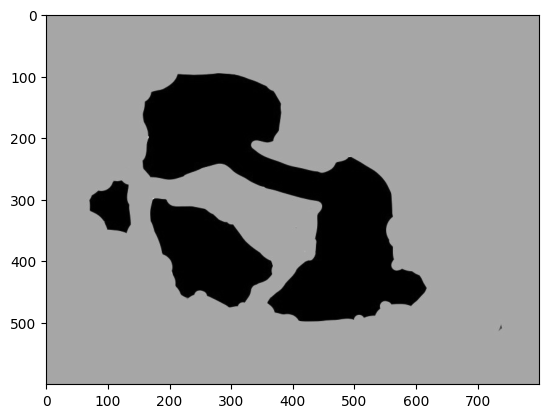

In [ ]:
label_image=cv2.imread('/content/drive/MyDrive/segment_data/segment/AABJ1_s.jpg')
label_image=cv2.cvtColor(label_image,cv2.COLOR_BGR2GRAY)
plt.imshow(label_image,cmap=plt.cm.gray)


In [ ]:
labels= label_image.reshape(-1)
df['labels']= labels
df.head()

,Original Pixels,gabor1,gabor2,gabor3,gabor4,gabor5,gabor6,gabor7,gabor8,gabor9,...,gabor64,Canny Edge,Roberts Edge,Sobel Edge,Scharr,Prewitt,gauss3,gauss7,median,labels
0,53,0,0,0,0,0,0,1,0,0,...,13,0,0.016169,0.011433,0.011433,0.011433,44,44,52,135
1,52,0,0,0,0,0,0,1,0,0,...,12,0,0.017538,0.013865,0.013865,0.013865,44,44,50,135
2,50,0,0,0,0,0,0,1,0,0,...,11,0,0.016867,0.016782,0.017025,0.016457,43,43,48,135
3,47,0,0,0,0,0,0,1,0,0,...,11,0,0.014139,0.015960,0.016007,0.015903,43,43,46,135
4,45,0,0,0,0,0,0,1,0,0,...,11,0,0.011433,0.012895,0.013137,0.012572,42,42,44,135


In [ ]:
Y=df['labels']
Y

0         135
1         135
2         135
3         135
4         135
         ... 
479995    135
479996    135
479997    135
479998    135
479999    135
Name: labels, Length: 480000, dtype: uint8

In [ ]:
X=df.drop(labels=['labels'],axis=1)
X.head()

,Original Pixels,gabor1,gabor2,gabor3,gabor4,gabor5,gabor6,gabor7,gabor8,gabor9,...,gabor63,gabor64,Canny Edge,Roberts Edge,Sobel Edge,Scharr,Prewitt,gauss3,gauss7,median
0,53,0,0,0,0,0,0,1,0,0,...,37,13,0,0.016169,0.011433,0.011433,0.011433,44,44,52
1,52,0,0,0,0,0,0,1,0,0,...,35,12,0,0.017538,0.013865,0.013865,0.013865,44,44,50
2,50,0,0,0,0,0,0,1,0,0,...,33,11,0,0.016867,0.016782,0.017025,0.016457,43,43,48
3,47,0,0,0,0,0,0,1,0,0,...,32,11,0,0.014139,0.015960,0.016007,0.015903,43,43,46
4,45,0,0,0,0,0,0,1,0,0,...,31,11,0,0.011433,0.012895,0.013137,0.012572,42,42,44


In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3, random_state=42)

In [ ]:

model=RandomForestClassifier(n_estimators=10,random_state=55)
model.fit(X_train,Y_train)
preds= model.predict(X_test)
score=metrics.accuracy_score(Y_test,preds)
print(score)

0.8503263888888889


In [ ]:
pickle.dump(model, open('drive/MyDrive/segment.pkl', 'wb'))